<a href="https://colab.research.google.com/github/ab2gbl/ECG-detection/blob/main/QRS_detection/TCN/TCN_QTDB%2BLUDB_4s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org' '/content/physionet.org'

In [1]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
from re import S
import os

In [2]:
def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=250, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed

In [3]:
def extract_qrs_regions(samples, symbols, fs, extra_ms=0):

    qrs_regions = []
    start = None
    nested_count = 0  # Track nested parentheses
    current_symbol = None  # Track if 'N' appears
    extra_samples = int((extra_ms / 1000) * fs)  # Convert ms to samples
    for i in range(len(symbols)):
        if symbols[i] == '(':
            if nested_count == 0:  # First `(` marks the start
                start = samples[i]
                current_symbol = None  # Reset tracking
            nested_count += 1  # Increase nested count

        elif symbols[i] == 'N':  # Identify QRS region
            current_symbol = 'N'

        elif symbols[i] == ')':
            nested_count -= 1  # Reduce nested count
            if nested_count == 0 and start is not None:
                if current_symbol == 'N':  # Only save if 'N' was in the segment
                    end = samples[i] + extra_samples
                    qrs_regions.append((start, end))
                start = None
                current_symbol = None  # Reset tracking

    return qrs_regions



In [4]:


def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal


def adjust_annotations(samples, original_fs, target_fs):
    return (samples * target_fs / original_fs).astype(int)



In [5]:

def create_binary_mask(signal, qrs_regions):
    mask = np.zeros(len(signal))
    for start, end in qrs_regions:
        mask[start:end] = 1  # Mark QRS regions as 1
    return mask


In [6]:
def segment_signal_and_mask(signal, mask, window_size, fs):
    segments = []
    masks = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        mask_segment = mask[i:i + window_size]
        segments.append(segment)
        masks.append(mask_segment)
    return np.array(segments), np.array(masks)


In [7]:

def process_record(record_path, Type, extra_ms=0):
    # Load signal
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]  # Use lead I
    if Type=='QTDB':
      annotations = wfdb.rdann(record_path, 'pu')
    else:
      annotations = wfdb.rdann(record_path, 'i')
    samples = annotations.sample  # Annotation sample locations
    symbols = annotations.symbol  # Annotation symbols
    fs = record.fs  # Sampling frequency (500 Hz)
    # Preprocess
    signal = smooth_signal(bandpass_filter(signal))

    # Extract QRS
    if Type=='QTDB':
      qrs_regions = extract_qrs_regions(samples, symbols,fs,extra_ms=extra_ms)
    else :
      qrs_regions = extract_qrs_regions(samples, symbols,fs)

    # Resampling to 250 Hz
    if fs!=250:
      # Example: Resample QTDB signal from 500 Hz to 250 Hz
      signal = resample_signal(signal, original_fs=fs, target_fs=250)


      # Example: Adjust QTDB annotations
      qrs_regions = [(adjust_annotations(start, original_fs=fs, target_fs=250),
                                  adjust_annotations(end, original_fs=fs, target_fs=250))
                                  for start, end in qrs_regions]
      fs=250

    # Create binary masks
    mask = create_binary_mask(signal, qrs_regions)


    # Segment the signals and masks
    window_size = int(1 * fs)  # 1-second window (based on LUDB's fs)
    segments, masks = segment_signal_and_mask(signal, mask, window_size, fs)

    return segments, masks


In [8]:
def get_all_records(directory, extension=".dat"):
    files = [f.replace(extension, "") for f in os.listdir(directory) if f.endswith(extension)]
    return list(set(files))  # Ensure no duplicates

# Set paths for QTDB and LUDB
qtdb_path = "/content/physionet.org/files/qtdb/1.0.0/"
ludb_path = "/content/physionet.org/files/ludb/1.0.1/data/"

# Get all record names dynamically
qt_records = get_all_records(qtdb_path)
lu_records = get_all_records(ludb_path)

print(f"Found {len(qt_records)} QTDB records and {len(lu_records)} LUDB records.")

Found 105 QTDB records and 200 LUDB records.


In [9]:
qt_segments_list, qt_masks_list = [], []

for record_path in qt_records:
    try:
        print(f"Processing {record_path}")
        segments, masks = process_record(qtdb_path+record_path, Type='QTDB', extra_ms=20)  # Resample to 250 Hz
        qt_segments_list.append(segments)
        qt_masks_list.append(masks)
    except:
        print(f"Skipping {record_path} due to error.")

Processing sel883
Processing sel14172
Processing sel47
Processing sele0124
Processing sel302
Processing sel223
Processing sel872
Processing sele0114
Processing sel16795
Processing sel33
Processing sel14046
Processing sele0112
Processing sele0211
Processing sel871
Processing sel39
Processing sel102
Processing sel16272
Processing sel31
Processing sel17453
Processing sel307
Processing sel803
Processing sel48
Processing sele0110
Processing sel231
Processing sel38
Processing sele0129
Processing sel45
Processing sel114
Processing sel44
Processing sel221
Processing sele0116
Processing sele0121
Processing sele0107
Processing sel42
Processing sel40
Processing sele0405
Processing sele0303
Processing sel46
Processing sele0509
Processing sel32
Processing sele0411
Processing sel30
Processing sel230
Processing sel808
Processing sele0203
Processing sele0406
Processing sele0166
Processing sel873
Processing sele0409
Processing sel116
Processing sele0170
Processing sele0704
Processing sel49
Processing s

In [10]:

lu_segments_list, lu_masks_list = [], []
for record_path in lu_records:
    try:
        print(f"Processing {record_path}")
        segments, masks = process_record(ludb_path+record_path, Type='LUDB', extra_ms=0)
        lu_segments_list.append(segments)
        lu_masks_list.append(masks)
    except:
        print(f"Skipping {record_path} due to error.")

Processing 142
Processing 41
Processing 4
Processing 143
Processing 17
Processing 121
Processing 55
Processing 48
Processing 77
Processing 66
Processing 28
Processing 159
Processing 129
Processing 195
Processing 155
Processing 52
Processing 89
Processing 86
Processing 59
Processing 171
Processing 38
Processing 94
Processing 175
Processing 151
Processing 126
Processing 116
Processing 78
Processing 15
Processing 56
Processing 189
Processing 136
Processing 149
Processing 60
Processing 166
Processing 162
Processing 183
Processing 113
Processing 22
Processing 168
Processing 93
Processing 44
Processing 9
Processing 33
Processing 111
Processing 73
Processing 47
Processing 191
Processing 1
Processing 6
Processing 80
Processing 40
Processing 23
Processing 63
Processing 102
Processing 196
Processing 3
Processing 135
Processing 178
Processing 176
Processing 12
Processing 65
Processing 68
Processing 115
Processing 185
Processing 165
Processing 98
Processing 197
Processing 27
Processing 128
Process

In [11]:
qt_segments = np.concatenate(qt_segments_list, axis=0)
qt_masks = np.concatenate(qt_masks_list, axis=0)
lu_segments = np.concatenate(lu_segments_list, axis=0)
lu_masks = np.concatenate(lu_masks_list, axis=0)

In [12]:
# Combine into final dataset
X = np.concatenate([qt_segments, lu_segments])
y = np.concatenate([qt_masks, lu_masks])

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [14]:
import numpy as np

# Define window size
window_size = int(4 * 250)  # 5 seconds * 250 Hz

# Function to pad both signal and mask
def pad_signal_and_mask(signal, mask, window_size):
    pad_length = window_size - (len(signal) % window_size)
    if pad_length != window_size:  # Only pad if not already divisible
        signal = np.pad(signal, (0, pad_length), mode='constant', constant_values=0)
        mask = np.pad(mask, (0, pad_length), mode='constant', constant_values=0)
    return signal, mask

# Apply padding to signals and masks
X_train_padded, y_train_padded = zip(*[pad_signal_and_mask(x, y, window_size) for x, y in zip(X_train, y_train)])
X_val_padded, y_val_padded = zip(*[pad_signal_and_mask(x, y, window_size) for x, y in zip(X_val, y_val)])
X_test_padded, y_test_padded = zip(*[pad_signal_and_mask(x, y, window_size) for x, y in zip(X_test, y_test)])

# Convert to NumPy arrays
X_train_padded, y_train_padded = np.array(X_train_padded), np.array(y_train_padded)
X_val_padded, y_val_padded = np.array(X_val_padded), np.array(y_val_padded)
X_test_padded, y_test_padded = np.array(X_test_padded), np.array(y_test_padded)

# Reshape into (batch, window_size, 1)
X_train = X_train_padded.reshape(-1, window_size, 1)
y_train = y_train_padded.reshape(-1, window_size, 1)

X_val = X_val_padded.reshape(-1, window_size, 1)
y_val = y_val_padded.reshape(-1, window_size, 1)

X_test = X_test_padded.reshape(-1, window_size, 1)
y_test = y_test_padded.reshape(-1, window_size, 1)

# Print shapes to verify
print(f"New Shape of X_train: {X_train.shape}, Y_train: {y_train.shape}")
print(f"New Shape of X_val: {X_val.shape}, Y_val: {y_val.shape}")
print(f"New Shape of X_test: {X_test.shape}, Y_test: {y_test.shape}")


New Shape of X_train: (123129, 1000, 1), Y_train: (123129, 1000, 1)
New Shape of X_val: (30783, 1000, 1), Y_val: (30783, 1000, 1)
New Shape of X_test: (38478, 1000, 1), Y_test: (38478, 1000, 1)


In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, Dense

def TCN(input_shape, num_filters, kernel_size, num_blocks, dropout_rate):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_blocks):
        # Residual block
        res = x
        x = Conv1D(num_filters, kernel_size, padding='causal')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv1D(num_filters, kernel_size, padding='causal')(x)
        x = BatchNormalization()(x)
        x = Add()([x, res])
        x = ReLU()(x)
    x = Conv1D(1, kernel_size=1, activation='sigmoid')(x)  # Output sequence of probabilities
    model = Model(inputs, x)
    return model
# Define the TCN model
input_shape = (window_size, 1)
model = TCN(input_shape, num_filters=64, kernel_size=3, num_blocks=4, dropout_rate=0.2)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1000, 1)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 1000, 64)       │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1000, 64)       │            256 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 1000, 64)       │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 1000, 64)       │         12,352 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 1000, 64)       │            256 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1000, 64)       │              0 │ batch_normalization_1… │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 1000, 64)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 1000, 64)       │         12,352 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 1000, 64)       │            256 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 1000, 64)       │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 1000, 64)       │         12,352 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 1000, 64)       │            256 │ conv1d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 1000, 64)       │              0 │ batch_normalization_3… │
│                           │                        │                │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 1000, 64)       │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 1000, 64)       │         12,352 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 88,833 (347.00 KB)

 Trainable params: 87,809 (343.00 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [17]:

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, batch_size=32)

Epoch 1/2
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 55s 14ms/step - accuracy: 0.9899 - loss: 0.0294 - val_accuracy: 0.9859 - val_loss: 0.0452
Epoch 2/2
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - accuracy: 0.9899 - loss: 0.0292 - val_accuracy: 0.9878 - val_loss: 0.0403


1203/1203 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9879 - loss: 0.0400
Test Accuracy: 0.9879054427146912
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


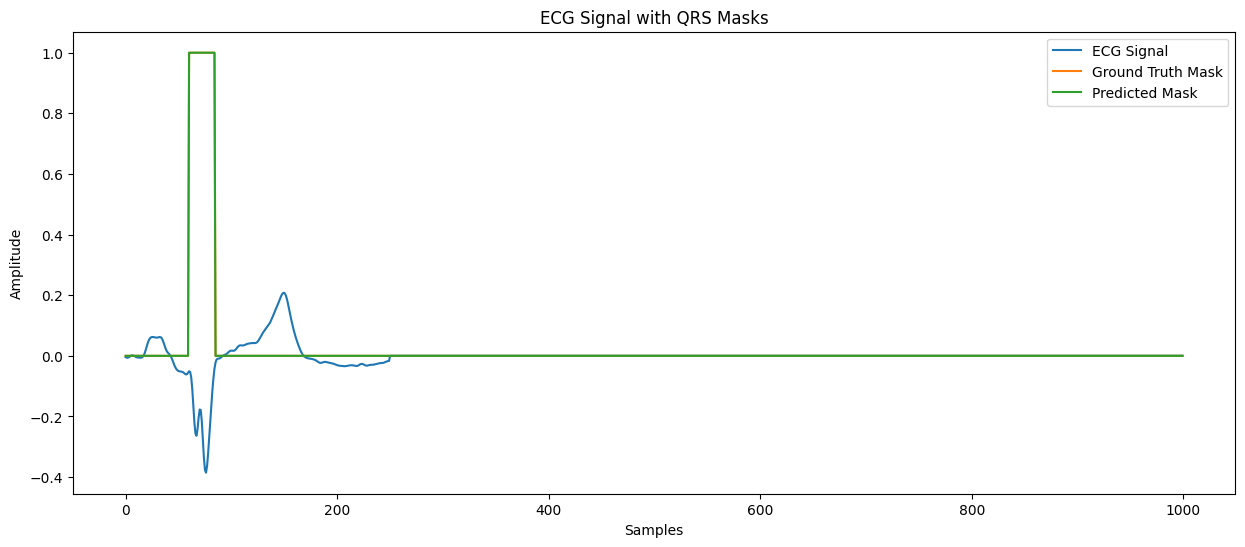

In [18]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

# Predict on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks

# Visualize predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(X_test[0].flatten(), label='ECG Signal')
plt.plot(y_test[0].flatten(), label='Ground Truth Mask')
plt.plot(y_pred[0].flatten(), label='Predicted Mask')
plt.title('ECG Signal with QRS Masks')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [19]:
from keras.saving import save_model

# Save the trained model
save_model(model,"/content/drive/MyDrive/Final project/QRS detection/TCN/TCN_4s_model.keras")
model.save("/content/drive/MyDrive/Final project/QRS detection/TCN/TCN_4s_model.keras")

In [46]:
import wfdb

window_size=4*250
# Function to pad a single signal
def pad_signal(signal, window_size):
    pad_length = window_size - (len(signal) % window_size)
    if pad_length != window_size:  # Only pad if not already divisible
        signal = np.pad(signal, (0, pad_length), mode='constant', constant_values=0)
    return signal
# Load the new ECG signal
new_record = wfdb.rdrecord('/content/physionet.org/files/mitdb/1.0.0/105')

new_signal = new_record.p_signal[:, 0]  # Use lead I
new_fs = new_record.fs  # Sampling frequency

# Extract the first 10 seconds
first_10_seconds = new_signal[:int(15 * new_fs)]
if new_fs!=250:
      # Example: Resample QTDB signal from 500 Hz to 250 Hz
      first_10_seconds = resample_signal(first_10_seconds, original_fs=new_fs, target_fs=250)
      new_fs=250


first_10_seconds = pad_signal(first_10_seconds, window_size)
print(first_10_seconds.shape)

(4000,)


In [47]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

first_10_seconds = smooth_signal(bandpass_filter(first_10_seconds))

first_10_seconds = resample_signal(first_10_seconds, original_fs=new_fs, target_fs=250)
# Segment the signal into fixed-length windows
def segment_signal(signal, window_size, fs):
    segments = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        segments.append(segment)
    return np.array(segments)

window_size = int(1 * new_fs)  # 1-second window
new_segments = segment_signal(first_10_seconds, window_size, new_fs)

# Reshape for TCN input
new_segments = new_segments.reshape(-1, window_size, 1)
print(new_segments.shape)

(30, 250, 1)


In [48]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks
print(y_pred[y_pred > 0])  # P
# Combine predictions into a single mask
full_mask = np.zeros(len(first_10_seconds))
for i, segment in enumerate(new_segments):
    start = i * (window_size // 2)
    end = start + window_size
    full_mask[start:end] = np.maximum(full_mask[start:end], y_pred[i].flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[[0.04374484]
  [0.08892023]
  [0.04670341]
  ...
  [0.03855579]
  [0.03826296]
  [0.04106786]]

 [[0.06558465]
  [0.04544113]
  [0.368689  ]
  ...
  [0.00573769]
  [0.00539718]
  [0.004907  ]]

 [[0.05669915]
  [0.0213244 ]
  [0.03407955]
  ...
  [0.150535  ]
  [0.05382532]
  [0.06451233]]

 ...

 [[0.06819545]
  [0.0345088 ]
  [0.14699772]
  ...
  [0.00643164]
  [0.00693668]
  [0.00698764]]

 [[0.0550005 ]
  [0.01841942]
  [0.04813769]
  ...
  [0.82587874]
  [0.5792096 ]
  [0.6416903 ]]

 [[0.17943144]
  [0.03953523]
  [0.03997358]
  ...
  [0.00306227]
  [0.00326337]
  [0.00349849]]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [49]:
def extract_qrs_from_mask(mask):
    qrs_regions = []
    start = None
    for i in range(len(mask)):
        if mask[i] == 1 and start is None:  # Start of QRS region
            start = i
        elif mask[i] == 0 and start is not None:  # End of QRS region
            end = i
            qrs_regions.append((start, end))
            start = None
    return qrs_regions

qrs_regions = extract_qrs_from_mask(full_mask)
print(qrs_regions)

[(115, 118), (125, 133), (134, 139), (299, 300), (307, 325), (338, 339), (344, 345), (470, 474), (482, 485), (501, 503), (649, 653), (661, 662), (663, 664), (672, 676), (829, 831), (841, 843), (852, 855), (1006, 1009), (1013, 1014), (1016, 1020), (1026, 1033), (1187, 1191), (1198, 1202), (1211, 1215), (1376, 1380), (1385, 1386), (1387, 1392), (1568, 1570), (1578, 1582), (1590, 1591), (1592, 1594), (1749, 1752), (1760, 1764), (1765, 1766), (1925, 1930), (1938, 1939), (2099, 2102), (2110, 2113), (2123, 2125), (2126, 2127), (2274, 2277), (2286, 2287), (2293, 2294), (2295, 2301), (2453, 2457), (2466, 2468), (2652, 2657), (2663, 2666), (2667, 2668), (2826, 2830), (2837, 2842), (3024, 3029), (3035, 3036), (3037, 3041), (3197, 3202), (3209, 3212), (3379, 3385), (3394, 3396), (3405, 3407), (3408, 3409), (3557, 3563), (3570, 3571), (3572, 3573), (3583, 3585), (3746, 3751)]


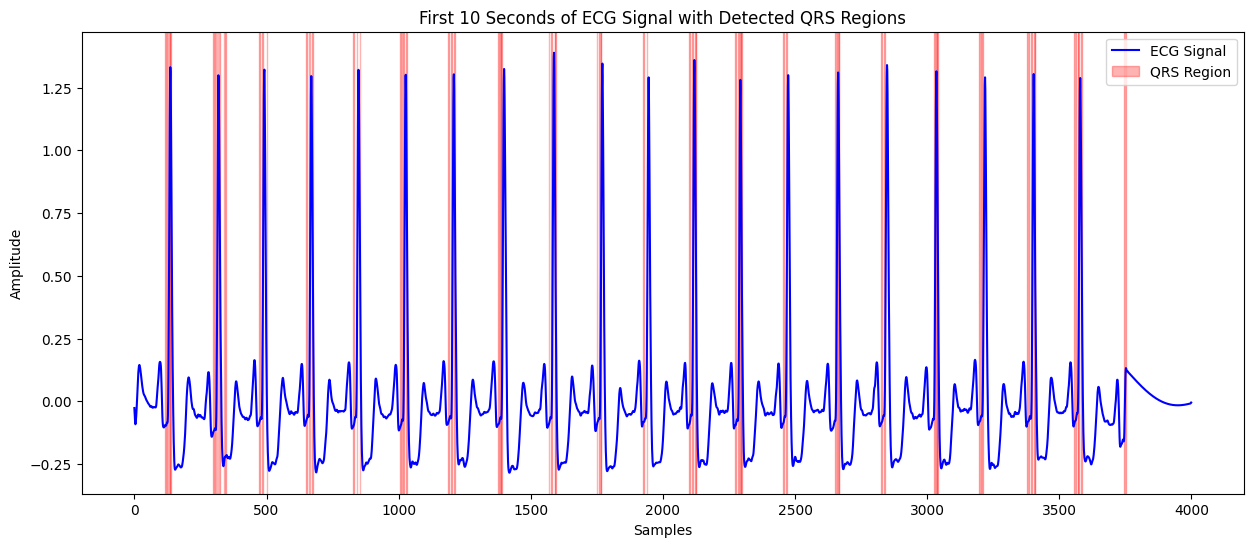

In [50]:
import matplotlib.pyplot as plt

# Plot the first 10 seconds of the ECG signal
plt.figure(figsize=(15, 6))
plt.plot(first_10_seconds, label='ECG Signal', color='b')

# Highlight QRS regions
for start, end in qrs_regions:
    plt.axvspan(start, end, color='r', alpha=0.3, label='QRS Region' if start == qrs_regions[0][0] else "")

plt.title('First 10 Seconds of ECG Signal with Detected QRS Regions')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
#plt.plot(y_pred[0].flatten(), label='Predicted Mask')
plt.legend()
plt.show()

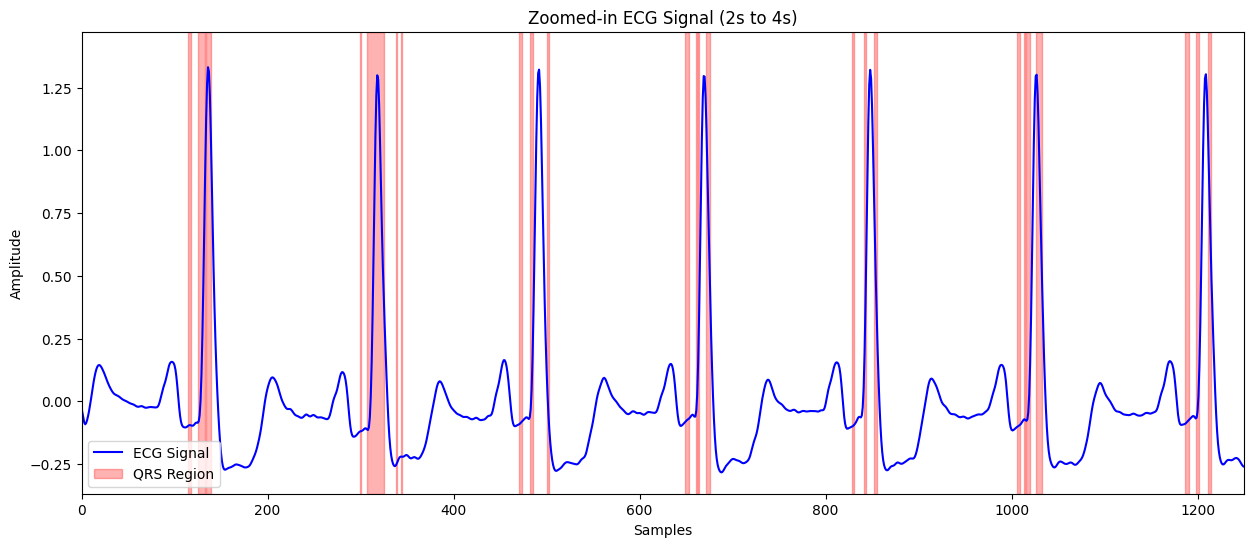

In [51]:
import matplotlib.pyplot as plt

# Define zoom-in range (e.g., focus on 2 to 4 seconds)
zoom_start = new_fs * 0  # Convert seconds to sample index
zoom_end = new_fs * 5

plt.figure(figsize=(15, 6))
plt.plot(first_10_seconds, label='ECG Signal', color='b')

# Highlight QRS regions within the zoomed-in range
for start, end in qrs_regions:
    if start >= zoom_start and end <= zoom_end:
        plt.axvspan(start, end, color='r', alpha=0.3, label='QRS Region' if start == qrs_regions[0][0] else "")

plt.xlim(zoom_start, zoom_end)  # Zoom into the selected range
plt.title('Zoomed-in ECG Signal (2s to 4s)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()
